# IMPORT LIBRARIES

In [1]:
import pandas as pd
import random
from pyomo.environ import *
import numpy as np
import time
import matplotlib.pyplot as plt


# IMPORT DATA

In [2]:
# --------------------------
# Synthetic dataset generator
# --------------------------
np.random.seed(42)  # reproducibility

n_rows = 500

# Ranges / progressive labels
ordini = [f"ORD_{i}" for i in range(1, 1001)]
articoli = [f"ART_{i}" for i in range(1, 201)]
clienti = [f"CLI_{i}" for i in range(1, 101)]
percorsi = [f"PER_{i}" for i in range(1, 31)]
ecr1_vals = [f"ECR1_{i}" for i in range(1, 6)]
ecr2_vals = [f"ECR2_{i}" for i in range(1, 6)]
ecr3_vals = [f"ECR3_{i}" for i in range(1, 6)]
ecr4_vals = [f"ECR4_{i}" for i in range(1, 6)]

# Build DataFrame
df = pd.DataFrame({
    "Num. Ordine": np.random.choice(ordini, n_rows),
    "Mese-Giorno": pd.date_range("2025-01-01", periods=n_rows, freq="D").strftime("%m-%d"),
    "Articolo": np.random.choice(articoli, n_rows),
    "Pezzi evasi": np.random.randint(1, 12, n_rows),
    "Ecr1": np.random.choice(ecr1_vals, n_rows),
    "Ecr2": np.random.choice(ecr2_vals, n_rows),
    "Ecr3": np.random.choice(ecr3_vals, n_rows),
    "Ecr4": np.random.choice(ecr4_vals, n_rows),
    "Cliente": np.random.choice(clienti, n_rows),
    "Percorso": np.random.choice(percorsi, n_rows),
    "Giacenza Pezzi Volume [m3]": np.round(np.random.uniform(0.1, 10.0, n_rows), 6),
    "Volume evaso [m3]": np.round(np.random.uniform(0.001, 1.0, n_rows), 6),
})

print("✅ Synthetic dataset created:")
print(df.head())

✅ Synthetic dataset created:
  Num. Ordine Mese-Giorno Articolo  Pezzi evasi    Ecr1    Ecr2    Ecr3  \
0     ORD_103       01-01   ART_67            8  ECR1_3  ECR2_2  ECR3_3   
1     ORD_436       01-02  ART_104            5  ECR1_4  ECR2_4  ECR3_2   
2     ORD_861       01-03  ART_174            2  ECR1_2  ECR2_4  ECR3_4   
3     ORD_271       01-04   ART_24            6  ECR1_2  ECR2_5  ECR3_3   
4     ORD_107       01-05  ART_114            5  ECR1_5  ECR2_1  ECR3_3   

     Ecr4 Cliente Percorso  Giacenza Pezzi Volume [m3]  Volume evaso [m3]  
0  ECR4_3  CLI_75   PER_21                    7.067544           0.547690  
1  ECR4_1  CLI_64   PER_16                    3.795272           0.991781  
2  ECR4_4  CLI_81    PER_2                    5.680234           0.664538  
3  ECR4_1  CLI_51    PER_2                    4.561796           0.200047  
4  ECR4_5  CLI_53   PER_23                    6.753355           0.045916  


# DEFINE FUNCTIONS

In [3]:
def initial_solution(gene_space, num_genes):
    """Generate a random initial solution (1D array of length num_genes)."""
    return np.random.choice(gene_space, size=num_genes)

In [4]:
gene_space = [0,1]
num_genes = len(df['Ecr2'].dropna().unique())
individual =  initial_solution(gene_space, num_genes)
individual

array([0, 1, 1, 0, 0])

In [5]:
def propose_neighbor(solution, gene_space, max_flips=2):
    """
    Propose a neighbor by flipping 1..`max_flips` random gene(s).
    If genes are binary {0,1}, flipping toggles the assignment.
    Otherwise, resample a different value from gene_space.
    """
    neighbor = solution.copy()
    n = len(neighbor)
    k = 1 if max_flips <= 1 else np.random.randint(1, max_flips + 1)
    flip_indices = np.random.choice(n, size=k, replace=False)
    for idx in flip_indices:
        curr = neighbor[idx]
        if set(gene_space) == {0, 1}:
            neighbor[idx] = 1 - curr
        else:
            choices = [g for g in gene_space if g != curr]
            neighbor[idx] = random.choice(choices)
    return neighbor

In [6]:
solution = individual.copy()     # population is a 1D array here
neighbor = propose_neighbor(individual, gene_space, max_flips=2)
neighbor

array([1, 1, 1, 0, 0])

In [7]:
def compute_fitness_unfitness_single(individual,
                                     df,
                                     stock,
                                     capacity_A,
                                     capacity_B,
                                     penalty_factor,
                                     fitness_type='BASE'):
    """
    Fitness (to MINIMIZE):
        fitness = 1 - (#AB_routes / #total_routes)
    Unfitness:
        capacity penalty as before.
    """
    unique_categories = df['Ecr2'].dropna().unique()
    df_allocation = pd.DataFrame({'Ecr2': unique_categories, 'Warehouse': individual})
    df_merged = pd.merge(df, df_allocation, on='Ecr2', how='left')
    df_merged['Warehouse'] = df_merged['Warehouse'].replace({0: 'A', 1: 'B'})

    if fitness_type == 'BASE':
        route_sets = (
            df_merged
            .groupby(['Mese-Giorno', 'Percorso'])['Warehouse']
            .apply(lambda x: set(x.unique()))
            .reset_index(name='WarehouseSet')
        )
        total_routes = len(route_sets)
        ab_routes = int(route_sets['WarehouseSet'].apply(lambda s: ('A' in s) and ('B' in s)).sum())
        pct_ab = (ab_routes / total_routes) if total_routes > 0 else 0.0

        individual_fitness = 1.0 - pct_ab
    else:
        individual_fitness = 0.0

    # Unfitness (capacity penalty) unchanged
    total_A = np.sum(individual * stock)
    total_B = np.sum((1 - individual) * stock)
    penalty = 0.0
    if total_A > capacity_A:
        penalty += penalty_factor * float(total_A - capacity_A)
    if total_B > capacity_B:
        penalty += penalty_factor * float(total_B - capacity_B)

    return float(individual_fitness), float(penalty)

In [8]:
# stock = np.ones(num_genes) 
stock = np.zeros(num_genes)
# capacity_A = 0 
# capacity_B = 0 
capacity_A = 999999999999999
capacity_B = 999999999999999
penalty_factor = 1

In [9]:
individual_fitness, penalty = compute_fitness_unfitness_single(individual,df,stock,capacity_A,capacity_B,penalty_factor,fitness_type='BASE')
individual_fitness, penalty

(0.9939393939393939, 0.0)

In [10]:
def energy_from(fitness, unfitness, weight_unfitness=1.0):
    """Scalar energy for SA (lower is better)."""
    return float(fitness) + weight_unfitness * float(unfitness)

In [11]:
energy = energy_from(individual_fitness, penalty, weight_unfitness=1.0)
energy

0.9939393939393939

In [ ]:
def main_sa(gene_space,
            num_genes,
            sol_per_pop,  # kept for compatibility; ignored in SA
            df,
            stock,
            capacity_A,
            capacity_B,
            M,
            penalty_factor,
            T_init=1.0,
            T_min=1e-4,
            alpha=0.995,
            max_seconds=24 * 60 *60,
            weight_unfitness=1.0,
            max_flips=2,
            seed=None,
            plot_every_seconds=None,   # ← set to a number (e.g., 60) to live-update plots
            live_tail=None             # ← optionally show only the last N points in live plots
            ):
    """
    Simulated Annealing optimizer for the warehouse allocation problem.

    Live plotting:
      - If plot_every_seconds is not None, two charts are refreshed every X seconds during the loop.
      - If live_tail is set (int), only the last N points are displayed.

    Stops when:
      - non_improving_iteration >= M, or
      - time exceeds max_seconds, or
      - temperature drops below T_min.

    Returns:
        best_solution (np.ndarray),
        best_fitness (float),
        best_unfitness (float),
        best_energy (float),
        computational_time (float),
        history (dict with curves)
    """
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    start_time = time.time()
    last_plot_time = start_time

    # History
    iterations = []
    best_fitness_history = []
    best_unfitness_history = []
    A_code_history = []
    B_code_history = []

    # Initial solution
    current = initial_solution(gene_space, num_genes)
    cur_fit, cur_unfit = compute_fitness_unfitness_single(current, df, stock, capacity_A, capacity_B, penalty_factor)
    cur_energy = energy_from(cur_fit, cur_unfit, weight_unfitness)

    best = current.copy()
    best_fit, best_unfit, best_energy = cur_fit, cur_unfit, cur_energy

    T = float(T_init)
    non_improving_iteration = 0
    iteration = 0

    while (T > T_min) and ((time.time() - start_time) < max_seconds) and (non_improving_iteration < M):
        iteration += 1

        neighbor = propose_neighbor(current, gene_space, max_flips=max_flips)
        n_fit, n_unfit = compute_fitness_unfitness_single(neighbor, df, stock, capacity_A, capacity_B, penalty_factor)
        n_energy = energy_from(n_fit, n_unfit, weight_unfitness)

        delta = n_energy - cur_energy
        accept = (delta <= 0) or (random.random() < np.exp(-delta / max(T, 1e-12)))

        if accept:
            current = neighbor
            cur_fit, cur_unfit, cur_energy = n_fit, n_unfit, n_energy
            if cur_energy < best_energy:
                best = current.copy()
                best_fit, best_unfit, best_energy = cur_fit, cur_unfit, cur_energy
                non_improving_iteration = 0
            else:
                non_improving_iteration += 1
        else:
            non_improving_iteration += 1

        # Geometric cooling
        T *= alpha

        # Track history (best-so-far)
        iterations.append(iteration)
        best_fitness_history.append(best_fit)
        best_unfitness_history.append(best_unfit)

        # Track A/B code counts for best solution
        unique_categories = df['Ecr2'].dropna().unique()
        df_alloc_best = pd.DataFrame({'Ecr2': unique_categories, 'Warehouse': best})
        df_merged_best = pd.merge(df, df_alloc_best, on='Ecr2', how='left')
        df_merged_best['Warehouse'] = df_merged_best['Warehouse'].replace({0: 'A', 1: 'B'})
        if 'Articolo' in df_merged_best.columns:
            A_code = df_merged_best[df_merged_best['Warehouse'] == 'A']['Articolo'].nunique()
            B_code = df_merged_best['Articolo'].nunique() - A_code
        else:
            A_code = 0
            B_code = 0
        A_code_history.append(A_code)
        B_code_history.append(B_code)

        # ---- Live plotting every X seconds ----
        if plot_every_seconds is not None and (time.time() - last_plot_time) >= plot_every_seconds:
            try:
                from IPython.display import clear_output, display
                clear_output(wait=True)
            except Exception:
                pass

            # tail slicing for clarity if requested
            if live_tail is not None and live_tail > 0:
                iters_plot = iterations[-live_tail:]
                fit_plot = best_fitness_history[-live_tail:]
                unfit_plot = best_unfitness_history[-live_tail:]
                A_plot = A_code_history[-live_tail:]
                B_plot = B_code_history[-live_tail:]
            else:
                iters_plot = iterations
                fit_plot = best_fitness_history
                unfit_plot = best_unfitness_history
                A_plot = A_code_history
                B_plot = B_code_history

            # Chart 1: Fitness & Unfitness (dual axis)
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax2 = ax1.twinx()
            ax1.plot(iters_plot, fit_plot, 'o-', label='Best Fitness')
            ax2.plot(iters_plot, unfit_plot, 'o-', label='Best Unfitness')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('Best Fitness')
            ax2.set_ylabel('Best Unfitness')
            ax1.set_title("Simulated Annealing (LIVE): Best Fitness & Unfitness")
            ax1.grid(True)
            fig.tight_layout()
            plt.show()

            # Chart 2: Code A & Code B (dual axis)
            fig2, ax3 = plt.subplots(figsize=(10, 6))
            ax4 = ax3.twinx()
            ax3.plot(iters_plot, A_plot, 'o-', label='Code A')
            ax4.plot(iters_plot, B_plot, 'o-', label='Code B')
            ax3.set_xlabel('Iteration')
            ax3.set_ylabel('Code A')
            ax4.set_ylabel('Code B')
            ax3.set_title("Simulated Annealing (LIVE): Code A/B evolution")
            ax3.grid(True)
            fig2.tight_layout()
            plt.show()

            last_plot_time = time.time()
        # ---- end live plotting ----

    computational_time = time.time() - start_time

    # Final plots: fitness vs unfitness (dual axis), and code counts
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(iterations, best_fitness_history, 'o-', label='Best Fitness')
    ax2.plot(iterations, best_unfitness_history, 'o-', label='Best Unfitness')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best Fitness')
    ax2.set_ylabel('Best Unfitness')
    ax1.set_title("Simulated Annealing: Best Fitness & Unfitness")
    ax1.grid(True)
    fig.tight_layout()
    plt.show()

    fig2, ax3 = plt.subplots(figsize=(10, 6))
    ax4 = ax3.twinx()
    ax3.plot(iterations, A_code_history, 'o-', label='Code A')
    ax4.plot(iterations, B_code_history, 'o-', label='Code B')
    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Code A')
    ax4.set_ylabel('Code B')
    ax3.set_title("Simulated Annealing: Code A/B evolution")
    ax3.grid(True)
    fig2.tight_layout()
    plt.show()

    history = {
        'iterations': iterations,
        'best_fitness_history': best_fitness_history,
        'best_unfitness_history': best_unfitness_history,
        'A_code_history': A_code_history,
        'B_code_history': B_code_history
    }

    return best, best_fit, best_unfit, best_energy, computational_time, history

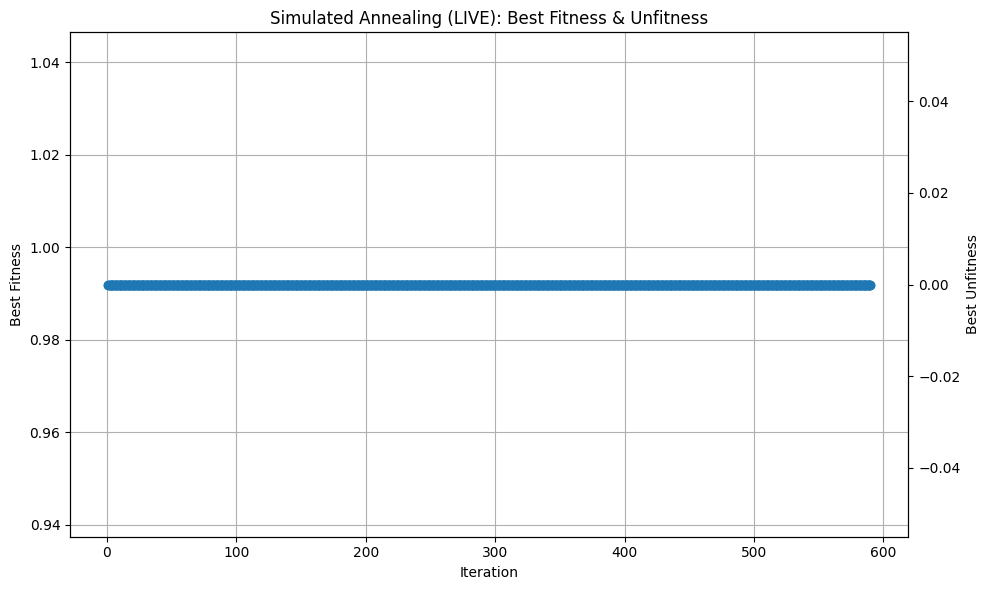

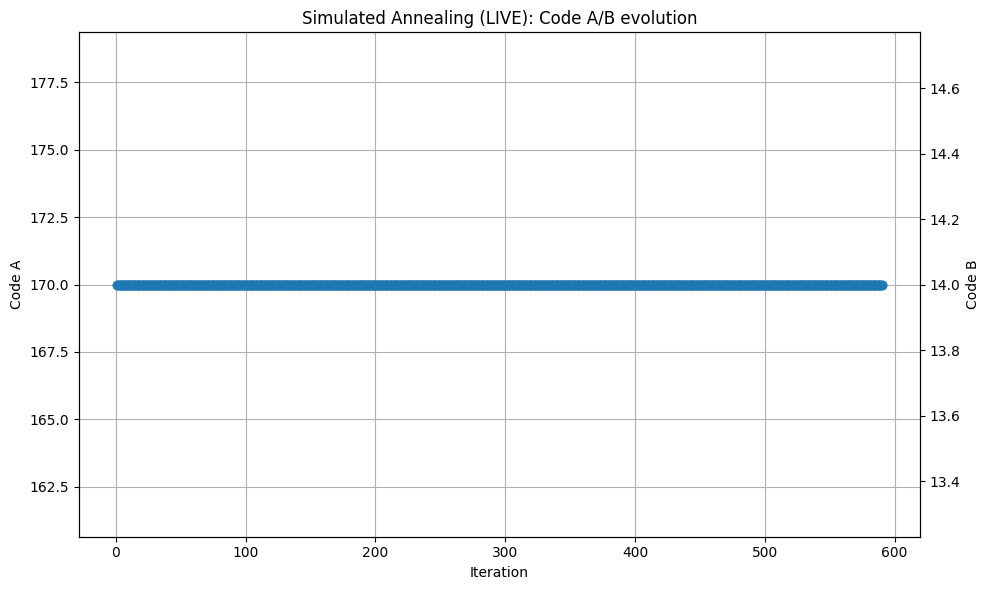

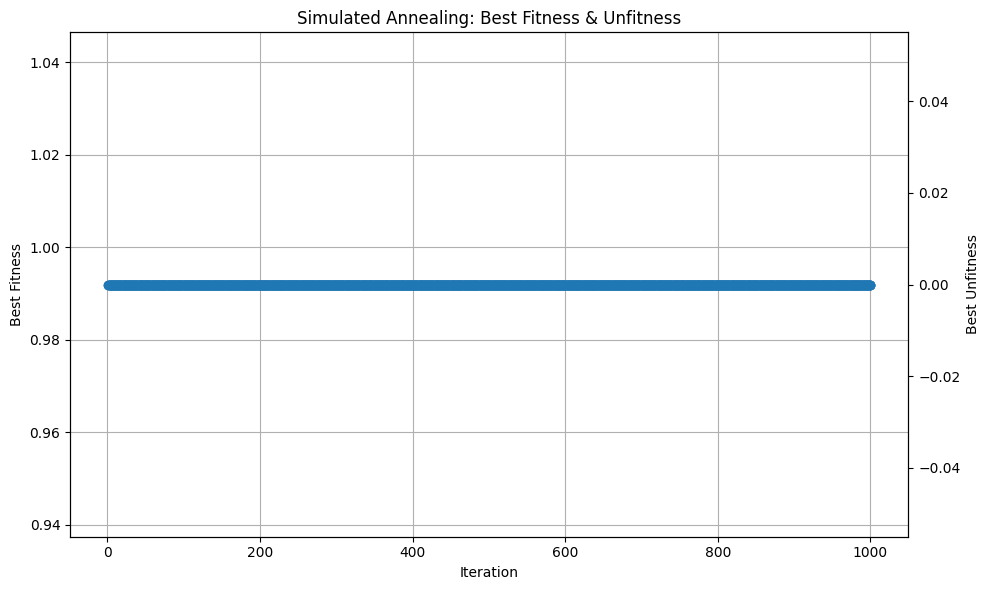

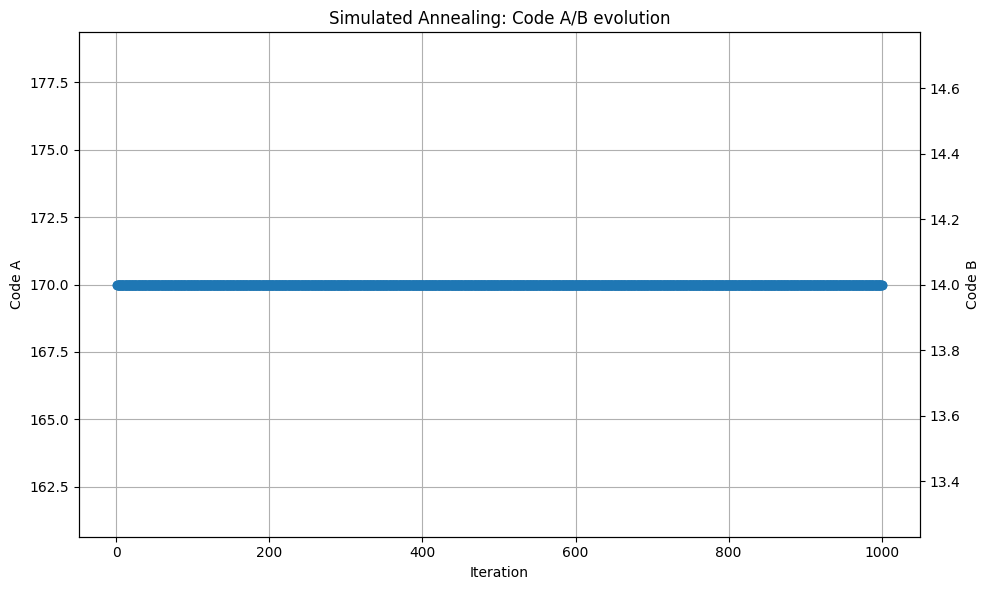

(array([0, 1, 0, 0, 0]),
 0.9919191919191919,
 0.0,
 0.9919191919191919,
 108.35369610786438,
 {'iterations': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,


In [13]:
# --------- Run Simulated Annealing ---------
# Assumes you have prepared: df, stock, capacity_A, capacity_B, M, penalty_factor

# Define gene space (binary 0/1 like the GA) and num_genes from your data
gene_space = [0, 1]
num_genes = len(df['Ecr2'].dropna().unique())
sol_per_pop = 1  # ignored by SA; kept for previous API compatibility

best, best_fit, best_unfit, best_energy, computational_time, history = main_sa(
            gene_space,
            num_genes,
            sol_per_pop,  # kept for compatibility; ignored in SA
            df,
            stock,
            capacity_A,
            capacity_B,
            M=1000,
            penalty_factor=1,
            T_init=1.0,
            T_min=1e-4,
            alpha=0.995,
            max_seconds=2*60,
            weight_unfitness=1.0,
            max_flips=2,
            seed=42,
            plot_every_seconds=60,   # ← set to a number (e.g., 60) to live-update plots
            live_tail=None             # ← optionally show only the last N points in live plots
)

best, best_fit, best_unfit, best_energy, computational_time, history

In [14]:
best

array([0, 1, 0, 0, 0])

## ALLOCATION

In [15]:
df_allocation = pd.DataFrame({'Ecr2': df['Ecr2'].dropna().unique()})
df_allocation['Warehouse'] = best
df_allocation

,Ecr2,Warehouse
0,ECR2_2,0
1,ECR2_4,1
2,ECR2_5,0
3,ECR2_1,0
4,ECR2_3,0


<Axes: xlabel='Ecr2'>

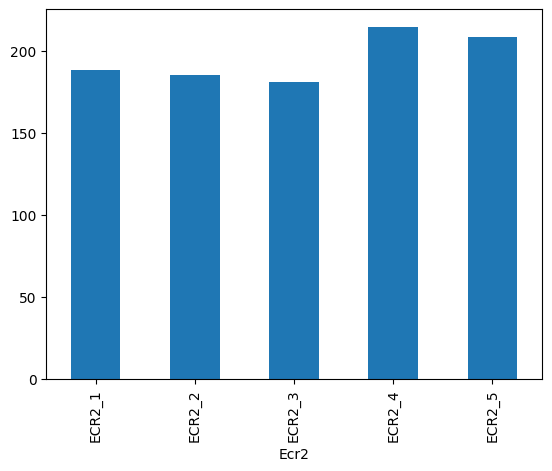

In [16]:
df.drop_duplicates(subset = 'Articolo').groupby('Ecr2')['Giacenza Pezzi Volume [m3]'].sum().plot.bar()

In [17]:
gene_space = [0,1]
num_genes = len(df['Ecr2'].dropna().unique())
penalty_factor = 1
M = 500000

stock = df.drop_duplicates(subset = 'Articolo').groupby('Ecr2')['Giacenza Pezzi Volume [m3]'].sum().values
# Define DC capacities (m3)
#capacity_A = 19800 * 0.37 #25000
#capacity_B =  12720 * 0.37 #6800

capacity_A = df.drop_duplicates(subset = 'Articolo').groupby('Ecr1')['Giacenza Pezzi Volume [m3]'].sum().sum()*0.65
capacity_B = df.drop_duplicates(subset = 'Articolo').groupby('Ecr1')['Giacenza Pezzi Volume [m3]'].sum().sum()*0.45

#stock = np.zeros(num_genes)
#capacity_A = 999999999999999
#capacity_B = 999999999999999

In [18]:
stock.sum(),capacity_A,capacity_B

(978.7980249999999, 636.21871625, 440.45911125000003)

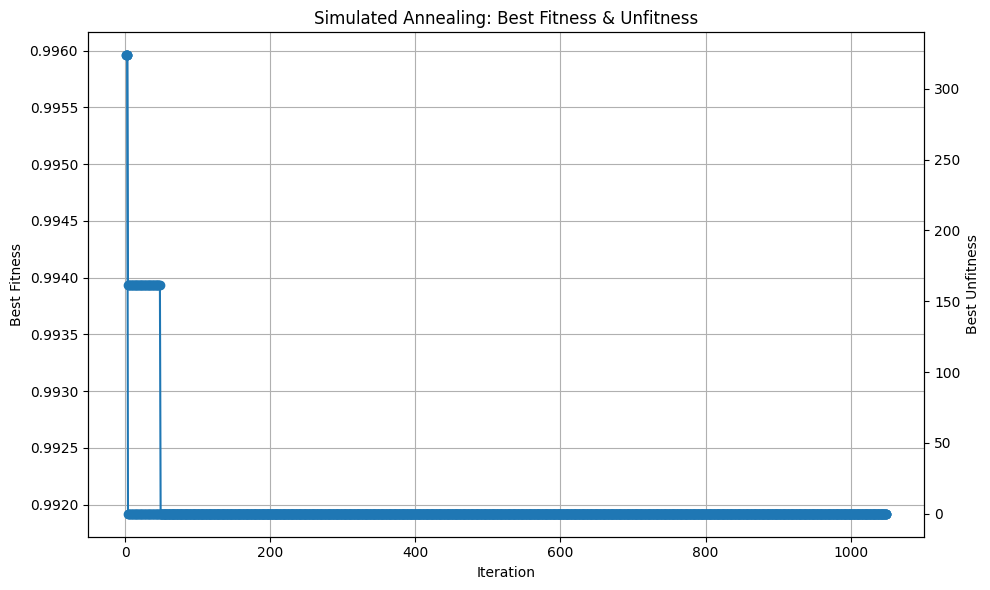

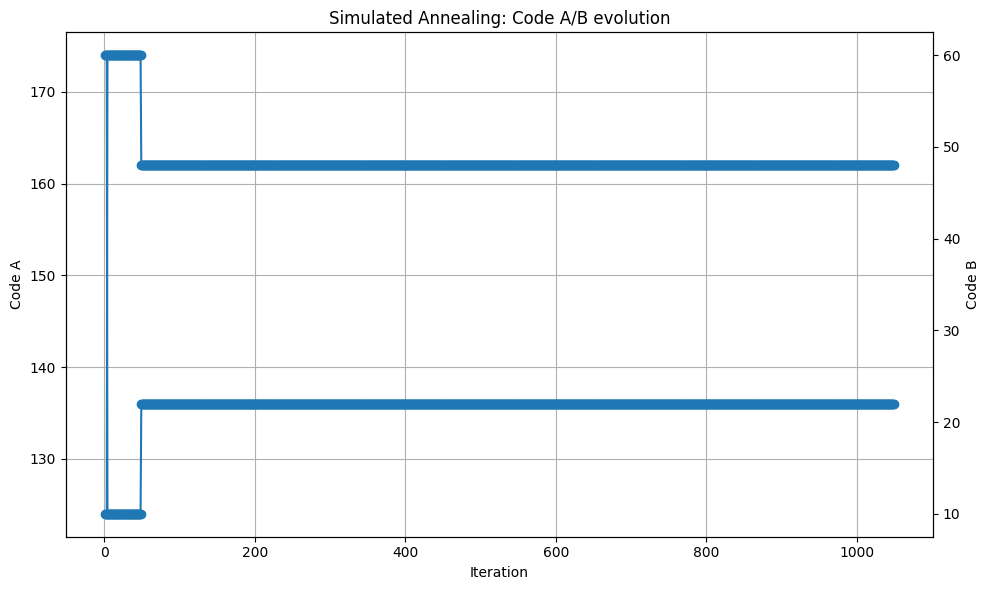

Best energy: 0.9919191919191919
Best fitness: 0.9919191919191919
Best unfitness: 0.0
Runtime (s): 111.10767364501953


,Ecr2,WarehouseCode,Warehouse
0,ECR2_2,0,A
1,ECR2_4,0,A
2,ECR2_5,1,B
3,ECR2_1,1,B
4,ECR2_3,1,B


In [19]:
best_solution, best_fitness, best_unfitness, best_energy, comp_time, history = main_sa(
            gene_space,
            num_genes,
            sol_per_pop,  # kept for compatibility; ignored in SA
            df,
            stock,
            capacity_A,
            capacity_B,
            M=1000,
            penalty_factor=1,
            T_init=1.0,
            T_min=1e-4,
            alpha=0.995,
            max_seconds=24*60*60,
            weight_unfitness=1.0,
            max_flips=2,
            seed=42,
            plot_every_seconds=60*10,   # ← set to a number (e.g., 60) to live-update plots
            live_tail=None             # ← optionally show only the last N points in live plots
)

print("Best energy:", best_energy)
print("Best fitness:", best_fitness)
print("Best unfitness:", best_unfitness)
print("Runtime (s):", comp_time)

# Final allocation mapping
unique_categories = df['Ecr2'].dropna().unique()
df_allocation = pd.DataFrame({'Ecr2': unique_categories, 'WarehouseCode': best_solution})
df_allocation['Warehouse'] = df_allocation['WarehouseCode'].replace({0: 'A', 1: 'B'})
df_allocation.head()

In [20]:
print("Global Best Individual:")
print(best_solution)
print("Global Fitness Values:")
print(best_fitness)
print("Global Unfitness Values:")
print(best_unfitness)
#print("Total Computational Time (sec):", comp_time)

Global Best Individual:
[0 0 1 1 1]
Global Fitness Values:
0.9919191919191919
Global Unfitness Values:
0.0


# STATISTICS

In [21]:
# Set a custom column width
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)  # or set a number like 1000

In [22]:
df_allocation = pd.DataFrame({'Ecr2': df['Ecr2'].dropna().unique()})
df_allocation['Warehouse'] = best_solution
df_allocation

,Ecr2,Warehouse
0,ECR2_2,0
1,ECR2_4,0
2,ECR2_5,1
3,ECR2_1,1
4,ECR2_3,1


In [23]:
df = pd.merge(df, df_allocation, on='Ecr2', how='left')
df['Warehouse'] = df['Warehouse'].replace({0: 'A', 1: 'B'})
df

,Num. Ordine,Mese-Giorno,Articolo,Pezzi evasi,Ecr1,Ecr2,Ecr3,Ecr4,Cliente,Percorso,Giacenza Pezzi Volume [m3],Volume evaso [m3],Warehouse
0,ORD_103,01-01,ART_67,8,ECR1_3,ECR2_2,ECR3_3,ECR4_3,CLI_75,PER_21,7.067544,0.547690,A
1,ORD_436,01-02,ART_104,5,ECR1_4,ECR2_4,ECR3_2,ECR4_1,CLI_64,PER_16,3.795272,0.991781,A
2,ORD_861,01-03,ART_174,2,ECR1_2,ECR2_4,ECR3_4,ECR4_4,CLI_81,PER_2,5.680234,0.664538,A
3,ORD_271,01-04,ART_24,6,ECR1_2,ECR2_5,ECR3_3,ECR4_1,CLI_51,PER_2,4.561796,0.200047,B
4,ORD_107,01-05,ART_114,5,ECR1_5,ECR2_1,ECR3_3,ECR4_5,CLI_53,PER_23,6.753355,0.045916,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD_18,05-11,ART_184,9,ECR1_3,ECR2_4,ECR3_3,ECR4_2,CLI_29,PER_15,7.180346,0.781138,A
496,ORD_793,05-12,ART_145,7,ECR1_1,ECR2_2,ECR3_5,ECR4_4,CLI_59,PER_2,2.890999,0.791672,A
497,ORD_735,05-13,ART_74,9,ECR1_4,ECR2_5,ECR3_3,ECR4_3,CLI_98,PER_30,3.701715,0.602867,B
498,ORD_566,05-14,ART_17,6,ECR1_2,ECR2_4,ECR3_3,ECR4_1,CLI_17,PER_21,1.988187,0.512127,A


In [24]:
df_results = pd.DataFrame.from_dict(
    {
        'Magazzino A': [],
        'Magazzino B':[],
        
        'Codici in A':[],
        'Codici in B':[],
        
        'Stock [m3] in A':[],
        'Stock [m3] in B':[],
        
        '% Ordini completati in AB':[],
        '% Ordini completati in A':[], 
        '% Ordini completati in B':[],

        'Vol[m3] Ordini completati in A':[], 
        'Vol[m3] Ordini completati in B':[],
        'Vol[m3] Ordini completati in AB':[],
        'Vol[m3] Ordini completati in AB (A)':[],
        'Vol[m3] Ordini completati in AB (B)':[],
        
        '% Rotte completate in AB' :[],
        '% Rotte completate in A' :[],
        '% Rotte completate in B' :[],

        'Vol[m3] Rotte completati in A' :[],
        'Vol[m3] Rotte completati in B' :[],
        'Vol[m3] Rotte completati in AB' :[],
        'Vol[m3] Rotte completati in AB (A)' :[],
        'Vol[m3] Rotte completati in AB (B)' :[],

    }
)
df_results

,Magazzino A,Magazzino B,Codici in A,Codici in B,Stock [m3] in A,Stock [m3] in B,% Ordini completati in AB,% Ordini completati in A,% Ordini completati in B,Vol[m3] Ordini completati in A,Vol[m3] Ordini completati in B,Vol[m3] Ordini completati in AB,Vol[m3] Ordini completati in AB (A),Vol[m3] Ordini completati in AB (B),% Rotte completate in AB,% Rotte completate in A,% Rotte completate in B,Vol[m3] Rotte completati in A,Vol[m3] Rotte completati in B,Vol[m3] Rotte completati in AB,Vol[m3] Rotte completati in AB (A),Vol[m3] Rotte completati in AB (B)


In [25]:
assignment_A = df.groupby('Warehouse')['Ecr2'].unique().get('A', 0)
assignment_B = df.groupby('Warehouse')['Ecr2'].unique().get('B', 0)

code_A = df.groupby('Warehouse')['Articolo'].nunique().get('A', 0)
code_B = df.groupby('Warehouse')['Articolo'].nunique().get('B', 0)
# print('Article division', article_division)

#Order analysis
order_grouped_df = df.groupby(['Mese-Giorno','Num. Ordine']).agg({
    'Warehouse': lambda x: list(x.unique()),  # Stores unique warehouses as lists
    'Volume evaso [m3]': 'sum'  # Sums up volume
}).reset_index()

order_movment_A = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(order_grouped_df) * 100
order_movment_B = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]) / len(order_grouped_df) * 100
order_movment_AB = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(order_grouped_df) * 100

order_vol_A = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum() 
order_vol_B = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]['Volume evaso [m3]'].sum() 
order_vol_AB = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum()

AB_order_list = list(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Num. Ordine'])
df_AB_order_volume = df.groupby(['Num. Ordine','Warehouse'])[['Volume evaso [m3]']].sum().reset_index()
df_AB_order_volume = df_AB_order_volume[df_AB_order_volume['Num. Ordine'].isin(AB_order_list)].groupby('Warehouse')['Volume evaso [m3]'].sum()

#Route analysis
route_grouped_df = df.groupby(['Mese-Giorno','Percorso']).agg({
    'Warehouse': lambda x: list(x.unique()),  # Stores unique warehouses as lists
    'Volume evaso [m3]': 'sum'  # Sums up volume
}).reset_index()

route_movment_A = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(route_grouped_df) * 100
route_movment_B = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]) / len(route_grouped_df) * 100
route_movment_AB = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(route_grouped_df) * 100

route_vol_A = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum() 
route_vol_B = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]['Volume evaso [m3]'].sum() 
route_vol_AB = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum()

# Step 1: Extract valid routes containing both 'A' and 'B' in 'Warehouse'
AB_order_list = route_grouped_df[
    route_grouped_df['Warehouse'].astype(str).str.contains(r'A') & 
    route_grouped_df['Warehouse'].astype(str).str.contains(r'B')
][['Mese-Giorno', 'Percorso']].apply(tuple, axis=1).tolist()

# Step 2: Compute total volume for each route
df_AB_route_volume = df.groupby(['Mese-Giorno', 'Percorso', 'Warehouse'])[['Volume evaso [m3]']].sum().reset_index()

# Step 3: Filter only the relevant routes and sum by Warehouse
df_AB_route_volume = df_AB_route_volume[
    df_AB_route_volume[['Mese-Giorno', 'Percorso']].apply(tuple, axis=1).isin(AB_order_list)
].groupby('Warehouse')['Volume evaso [m3]'].sum()


weighted_stock = df.groupby(['Articolo','Warehouse',])['Giacenza Pezzi Volume [m3]'].mean() * (df.groupby(['Articolo','Warehouse',])['Pezzi evasi'].sum() / df.groupby(['Articolo'])['Pezzi evasi'].sum())
stock_A = weighted_stock.groupby('Warehouse').sum().get('A', 0)
stock_B = weighted_stock.groupby('Warehouse').sum().get('B', 0)

df_results = pd.DataFrame.from_dict(
    {
        'Magazzino A': [assignment_A],
        'Magazzino B': [assignment_B],
        
        'Codici in A':[code_A],
        'Codici in B':[code_B],
        
        'Stock [m3] in A':[stock_A],
        'Stock [m3] in B':[stock_B],
        
        '% Ordini completati in AB':[order_movment_AB],
        '% Ordini completati in A':[order_movment_A],
        '% Ordini completati in B':[order_movment_B],

        '% Rotte completate in AB':[route_movment_AB],
        '% Rotte completate in A':[route_movment_A],
        '% Rotte completate in B':[route_movment_B],

        'Vol[m3] Ordini completati in A':[order_vol_A],
        'Vol[m3] Ordini completati in B':[order_vol_B],
        'Vol[m3] Ordini completati in AB':[order_vol_AB],
        'Vol[m3] Ordini completati in AB (A)':[df_AB_order_volume.get('A', 0)],
        'Vol[m3] Ordini completati in AB (B)':[df_AB_order_volume.get('B', 0)],


        'Vol[m3] Rotte completati in A':[route_vol_A],
        'Vol[m3] Rotte completati in B':[route_vol_B],
        'Vol[m3] Rotte completati in AB':[route_vol_AB],
        'Vol[m3] Rotte completati in AB (A)' :[df_AB_route_volume.get('A', 0)],
        'Vol[m3] Rotte completati in AB (B)' :[df_AB_route_volume.get('B', 0)],

        
    }
)